# **Colab + PyTorch + Google Drive進行自定義模型及資料集影像分類訓練**
歐尼克斯實境互動工 作室 OmniXRI Jack 2020.12.18整理製作

本範例從雲端下載資料集到虛擬機，再連接雲端硬碟Google Drive儲存訓練好的模型，主要使用PyTorch進行程式開發。

執行本範例前，請先確認系統已處於GPU開啟模式，選單【編輯】─【筆記本設定】─【硬體加速器】─ GPU。

主要工作如下

*   掛載雲端硬碟到虛擬機
*   複製資料集到虛擬機
*   取得資料集路徑
*   製作PyTorch格式資料集
*   隨機取出批次資料 (option)
*   建立卷積神經網路
*   開始訓練模型及權重
*   儲存訓練好的模型及參數
*   繪製損失函數曲線 (option)













In [1]:
!nvidia-smi # 檢查GPU硬體環境及CUDA版本

Thu Dec 17 16:03:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import tensorflow as tf
import cv2
import sys

print(sys.version) # 檢查Python版本
print(torch.__version__) # 檢查PyTorch版本
print(tf.__version__) # 檢查TensorFlow版本
print(cv2.__version__) # 檢查OpenCV版本

3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
1.7.0+cu101
2.3.0
4.1.2


# **掛載雲端硬碟到虛擬機**

In [3]:
# 導入Google Drvie套件包
from google.colab import drive

# 將自己的雲端硬碟掛載到Colab虛擬機上
# 參考資料來源:https://colab.research.google.com/drive/1i41Whco5KIb7EuntKYwTVORAkAwCmlkF
drive.mount('/content/gdrive')

# 點選 Go to this URL in a browser: 後的網址，並複製授權碼(Authorization Code)
# 貼到到下方 Authorization Code 空格位置
# 雲端硬碟成功掛載到Colab虛擬機下 /content/gdriver/MyDrive 
# 點選畫面左方檔案夾圖示亦能看到掛載結果

# 本範例最後完成訓練的模型及參數會存放在雲端硬碟指定路徑下

# 列出掛載之硬碟目錄
!ls /content/gdrive/MyDrive/test
# 顯示目前虛擬機工作路徑
!pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
cats_and_dogs_filtered.zip  OmniXRI_Logo.jpg	  PyTorch_Test1.ipynb
dict.pt			    OmniXRI_Logo.mp4
OmniXRI_Logo_avc.mp4	    OmniXRI_Logo_out.mp4
/content


# **複製資料集到虛擬機**

在Colab虛擬機上硬碟創建/dataset路徑，將資料集(cats_and_dogs_filtered.zip)從網路上下載到/dataset並解壓縮。該資料集只訓練用的貓狗圖片各1000張，檔名為cat.n.jpg 及 dog.n.jpg，n為0999，驗證用的貓狗圖片各500張，檔名為cat.n.jpg 及 dog.n.jpg，n為2000到2499。
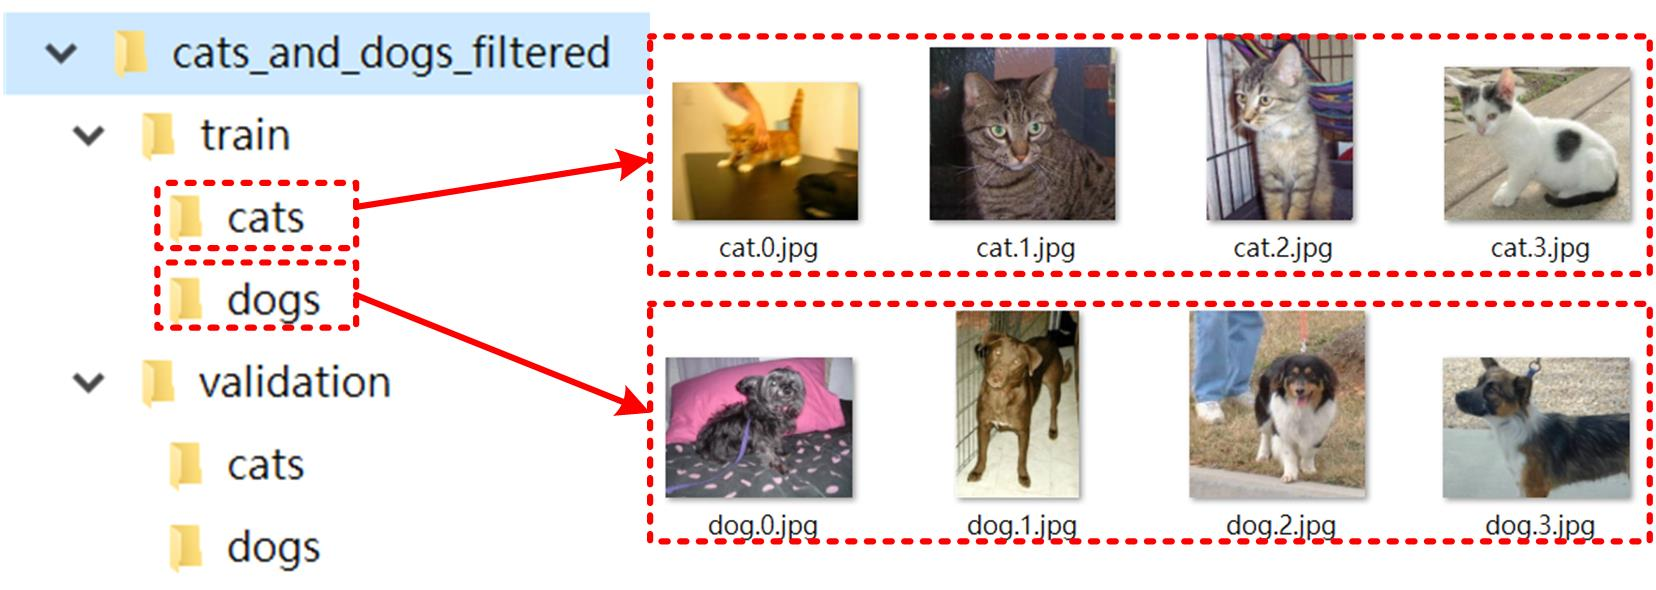

In [4]:
# 建立/dataset路徑
!mkdir /content/dataset 
# 下載資料集到虛擬機硬碟
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /content/dataset/cats_and_dogs_filtered.zip 
# 解壓縮資料集
!unzip /content/dataset/cats_and_dogs_filtered.zip -d /content/dataset 
# 列出資料集路徑清單
!ls /content/dataset 

mkdir: cannot create directory ‘/content/dataset’: File exists
--2020-12-17 16:03:45--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 2607:f8b0:400e:c08::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/dataset/cats_and_dogs_filtered.zip’

/content/dataset/ca 100%[===================>]  65.43M   155MB/s    in 0.4s    

2020-12-17 16:03:45 (155 MB/s) - ‘/content/dataset/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Archive:  /content/dataset/cats_and_dogs_filtered.zip
replace /content/dataset/cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
cats_and_dogs_filtered	cats_and_dogs_filtered.zip


# **取得資料集路徑**

包含基礎、訓練及驗證資料集路徑名稱。

In [5]:
import os

# 取得資料集路徑
base_dir = '/content/dataset/cats_and_dogs_filtered'  # 取得資料集的基礎路徑名稱
train_dir = os.path.join(base_dir, 'train')           # 取得訓練資料集的路徑名稱
validation_dir = os.path.join(base_dir, 'validation') # 取得驗證資料集的路徑名稱

train_cats_dir = os.path.join(train_dir, 'cats')           # 取得訓練用貓圖片的路徑
train_dogs_dir = os.path.join(train_dir, 'dogs')           # 取得訓練用狗圖片的路徑
validation_cats_dir = os.path.join(validation_dir, 'cats') # 取得驗證用貓圖片的路徑
validation_dogs_dir = os.path.join(validation_dir, 'dogs') # 取得驗證用狗圖片的路徑

train_cat_fnames = os.listdir(train_cats_dir)              # 取得訓練用所有貓圖片名稱
train_dog_fnames = os.listdir(train_dogs_dir)              # 取得訓練用所有狗圖片名稱
validation_cat_fnames = os.listdir(validation_cats_dir)    # 取得驗證用所有貓圖片名稱
validation_dog_fnames = os.listdir(validation_dogs_dir)    # 取得驗用所有狗圖片名稱

# **列出資料集影像部份影像**

僅方便檢查用，這段程式可忽略，不用執行。

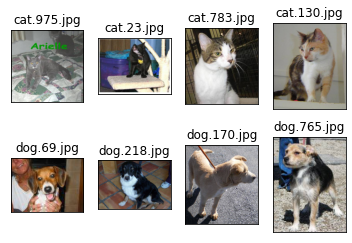

In [6]:
import matplotlib.pyplot as plt # 導入matplotlib繪圖相關函式
import matplotlib.image as mpimg # 導入matplotlib影像處理相闗函式

# 設定顯示圖像內容，貓狗各4張
cat_pic = [os.path.join(train_cats_dir, fname) 
             for fname in train_cat_fnames[:4]]
dog_pic = [os.path.join(train_dogs_dir, fname) 
             for fname in train_dog_fnames[:4]]

# 將取得圖像內容繪製至容器中
for i, img_path in enumerate(cat_pic+dog_pic):
  plt.subplot(2, 4, i + 1)
  plt.xticks([]), plt.yticks([]) # 取消X,Y軸標示及格線
  plt.title(os.path.basename(img_path)) # 將檔名加到標題
  img = mpimg.imread(img_path) # 讀取指定影像
  plt.imshow(img) # 顯示子圖

# 顯示最後結果
plt.show()

# **製作PyTorch格式資料集**

通常可使用一張影像一個標籤或者一個路徑共用一個標籤，本範例選擇後者。

為了使輸入資料格式能統一，這裡利用torchvision的轉換函式將影像強制縮放到224x224像素，且將數值從0到255正規化至-1到+1範圍，最後使用ImageFolder函式建立PyTorch格式的訓練資料集。

torchvision 提供許多現成的資料集、轉換（資料擴增）方法及深度學習模型。
可參考 https://pytorch.org/docs/stable/torchvision/index.html

In [7]:
import torch # 導入PyTorch函式庫
import torch as nn # 導入PyTorch函式庫
import torch.optim as optim # 導入PyTorch優化器相關函式
from torchvision import datasets, transforms, models # 導入torchvision中資料集、轉換及模型相關函數

train_transforms = transforms.Compose([transforms.Resize((224,224)), # 將輸入影像強制縮放至224x224像素
                                       #transforms.RandomResizedCrop(224), # 輸入影像隨機截切並縮放至224x224像素
                                       #transforms.RandomHorizontalFlip(), # 輸人影像隨機水平翻轉
                                       transforms.ToTensor(), # 建立張量
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) # 使資料正規化到 -1 ~ +1
                                      ])
train_data = datasets.ImageFolder(train_dir, transform=train_transforms) # 建立PyTorch格式訓練資料集

print('Label: ', train_data.class_to_idx) # 將貓和狗的標籤（類別）轉成0和1
print('Image Path: ', train_data.imgs[0]) # 列出訓練資料集中第一張影像名稱及標籤
print(train_data[0][0]) # 列出訓練資料集中第一張影像的原始數據
print(train_data[0][1]) # 列出訓練資料集中第一張影像的標籤

for i in range(5):
  print('Image Size: ', train_data[i][0].shape) # 列出訓練資料集中前五張的資料（維度）大小

Label:  {'cats': 0, 'dogs': 1}
Image Path:  ('/content/dataset/cats_and_dogs_filtered/train/cats/cat.0.jpg', 0)
tensor([[[ 0.5922,  0.6078,  0.6392,  ...,  0.9216,  0.8902,  0.8745],
         [ 0.5922,  0.6078,  0.6392,  ...,  0.9216,  0.8980,  0.8824],
         [ 0.5922,  0.6078,  0.6392,  ...,  0.9216,  0.9059,  0.8902],
         ...,
         [ 0.2078,  0.2157,  0.2235,  ..., -0.9765, -0.9765, -0.9765],
         [ 0.2000,  0.2000,  0.2078,  ..., -0.9843, -0.9843, -0.9843],
         [ 0.1843,  0.1922,  0.2000,  ..., -0.9922, -0.9922, -0.9922]],

        [[ 0.2863,  0.3020,  0.3333,  ...,  0.6000,  0.5843,  0.5686],
         [ 0.2863,  0.3020,  0.3333,  ...,  0.6000,  0.5922,  0.5765],
         [ 0.2863,  0.3020,  0.3333,  ...,  0.6000,  0.6000,  0.5843],
         ...,
         [-0.0353, -0.0275, -0.0196,  ..., -0.9765, -0.9765, -0.9765],
         [-0.0431, -0.0431, -0.0353,  ..., -0.9843, -0.9843, -0.9843],
         [-0.0588, -0.0510, -0.0431,  ..., -0.9922, -0.9922, -0.9922]],

    

# **使用DataLoader隨機取出批次資料**

此部份僅供檢查用，可忽略不執行。

In [8]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)

for i, (data, label) in enumerate(train_loader):
  if i<5 :
    print(f'[{i+1}] {data.shape}, {label}')
  else:
    break

[1] torch.Size([16, 3, 224, 224]), tensor([0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1])
[2] torch.Size([16, 3, 224, 224]), tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1])
[3] torch.Size([16, 3, 224, 224]), tensor([1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0])
[4] torch.Size([16, 3, 224, 224]), tensor([0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1])
[5] torch.Size([16, 3, 224, 224]), tensor([1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1])


# **建立卷積神經網路**



In [9]:
import torch # 導入PyTorch函式庫
import torch.nn as nn # 導入PyTorch函式庫
import torch.nn.functional as F #導入神經網路相關函式庫

class CNN(nn.Module): # 建立CNN類別函式
    def __init__(self, batch ): # 函數初始化
        super(CNN, self).__init__()
        # 定義第一卷積及最大池化層
        self.conv_1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) 
        self.maxpool_1 = nn.MaxPool2d(kernel_size=2)
        # 定義第二卷積及最大池化層
        self.conv_2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool_2 = nn.MaxPool2d(kernel_size=2)
        # 定義第三卷積及最大池化層
        self.conv_3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.maxpool_3 = nn.MaxPool2d(kernel_size=2)
        #定義第一全連接層
        self.fc_1 = nn.Linear(128*(28*28) , 512)
        #定義第二全連接層
        self.fc_2 = nn.Linear(512, 2) # 重要，輸出2個類別
        
    def forward(self, x): # 正向推論函式
        
        out = self.maxpool_1(F.relu(self.conv_1(x))) # 執行第一卷積及池化層
        out = self.maxpool_2(F.relu(self.conv_2(out))) # 執行第二卷積及池化層
        out = self.maxpool_3(F.relu(self.conv_3(out))) # 執行第三卷積及池化層
        out = out.view(-1, self.num_flat_features(out)) # 執行平坦化
        out = F.relu(self.fc_1(out)) # 執行第一全連接層
        out = F.softmax(self.fc_2(out)) # 執行第二全連接層
        return out # 得到最後輸出並返回
    
    def num_flat_features(self, x): # 計算平坦化特徵數量
        size = x.size()[1:] # 求得資料集大小
        num_features = 1

        for s in size:
            num_features *= s # 求特徵數量

        return num_features # 返回特徵值數量  

# **測試模型並列出執行結果**

此部份僅供檢查用，可忽略不執行。

In [10]:
batch_size = 16 
model = CNN(batch_size)
print(model)
test = torch.rand([batch_size,3,224,224])
print(model(test))

CNN(
  (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=100352, out_features=512, bias=True)
  (fc_2): Linear(in_features=512, out_features=2, bias=True)
)
tensor([[0.5063, 0.4937],
        [0.5055, 0.4945],
        [0.5059, 0.4941],
        [0.5055, 0.4945],
        [0.5046, 0.4954],
        [0.5040, 0.4960],
        [0.5066, 0.4934],
        [0.5068, 0.4932],
        [0.5060, 0.4940],
        [0.5052, 0.4948],
        [0.5061, 0.4939],
        [0.5056, 0.4944],
        [0.5055, 0.4945],
        [0.5065, 0.4935]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


# **開始訓練模型及權重**


In [11]:
import torch.optim as optim # 導入PyTorch優化器相關函式
import matplotlib.pyplot as plt # 導入matplotlib繪圖相關函式
import time # 導入計時相關函數

# 設定訓練基本參數
epochs = 5 # 訓練迭代次數（所有資料集跑完epochs次）
batchs = 32 # 批次取樣數量（一次取batchs張影像計算）
lr = 1e-4 # 學習率（可另設為變動式）
step = 0 # 步階次數
train_loss = [] # 訓練損失
test_loss = [] # 測試損失

# 設定裝置，預設以GPU（CUDA）執行，若無則採CPU計算
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 隨機讀取批量影像進行訓練，shuffle = True表啟動隨機取樣
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batchs, shuffle=True)
# 以GPU（CUDA）產生模型
model = CNN(batchs).to('cuda')
# 選用交叉熵損失函數
loss_fn = nn.CrossEntropyLoss()
# 選用Adam優化器函式
opt = optim.Adam(model.parameters(), lr= lr)

start = time.time() # 開始計時
model.train() # 模型訓練

print('開始訓練')
for i in range(epochs+1): # 設定迭代次數
    
    print('迭代次數: {}\n'.format(i+1)) # 列出目前迭代次數
    training_loss = 0 # 初始損失設為零
    epoch_time = time.time() # 開始迭代時間
    
    for idx, (data, label) in enumerate(train_loader): # 讀取資料集
        
        data, label = data.to(device), label.to(device) # 將模型及標籤載入裝置
        
        step += 1 # 步階加一
        predict = model(data) # 產生預測結果
        loss = loss_fn( predict, label) # 計算預測損失
        
        training_loss += loss.item() # 累加損失

        opt.zero_grad() # 把優化器梯度歸零
        
        loss.backward() # 反向傳播
        
        opt.step() # 優化器步進
        
        if(idx==0 or idx%10==0): # 每執行十次，列出執行結果
            print('[{}/{}] [{:04}/{:4}] loss:{:.6f}'.format(i, epochs, idx, int(25000/16) ,loss.item()))
    
    train_loss.append(training_loss*batchs/len(train_loader.dataset)) # 添加訓練損失並列出
    print("[{}/{}] loss:{:8.6f} time:{}".format(i, epochs, train_loss[i], time.time()-epoch_time))

end = time.time() # 結束計時 
print('Cost time:', end-start) # 列出所有工作時間

開始訓練
迭代次數: 1



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[0/5] [0000/1562] loss:0.692667
[0/5] [0010/1562] loss:0.687708
[0/5] [0020/1562] loss:0.707576
[0/5] [0030/1562] loss:0.684027
[0/5] [0040/1562] loss:0.697789
[0/5] [0050/1562] loss:0.719858
[0/5] [0060/1562] loss:0.626309
[0/5] loss:0.692937 time:11.004943609237671
迭代次數: 2

[1/5] [0000/1562] loss:0.660371
[1/5] [0010/1562] loss:0.606122
[1/5] [0020/1562] loss:0.766701
[1/5] [0030/1562] loss:0.584551
[1/5] [0040/1562] loss:0.677049
[1/5] [0050/1562] loss:0.604342
[1/5] [0060/1562] loss:0.654658
[1/5] loss:0.629426 time:10.87709903717041
迭代次數: 3

[2/5] [0000/1562] loss:0.615195
[2/5] [0010/1562] loss:0.590925
[2/5] [0020/1562] loss:0.670795
[2/5] [0030/1562] loss:0.695295
[2/5] [0040/1562] loss:0.519901
[2/5] [0050/1562] loss:0.615381
[2/5] [0060/1562] loss:0.577504
[2/5] loss:0.606172 time:10.942269563674927
迭代次數: 4

[3/5] [0000/1562] loss:0.564872
[3/5] [0010/1562] loss:0.565177
[3/5] [0020/1562] loss:0.537515
[3/5] [0030/1562] loss:0.508050
[3/5] [0040/1562] loss:0.493782
[3/5] [005

# **儲存訓練好的模型及參數**

In [12]:
# 儲存模型及參數到雲端硬碟
torch.save(model.state_dict(), '/content/gdrive/MyDrive/test/dict.pt') 
# 檢查模型及參數是否成功儲存至雲端硬碟
!ls /content/gdrive/MyDrive/test 

cats_and_dogs_filtered.zip  OmniXRI_Logo.jpg	  PyTorch_Test1.ipynb
dict.pt			    OmniXRI_Logo.mp4
OmniXRI_Logo_avc.mp4	    OmniXRI_Logo_out.mp4


# **繪製損失函數曲線**

從圖上可看出損失值越來越小，有訓練成功的趨勢。這部份視需要可略過不執行。

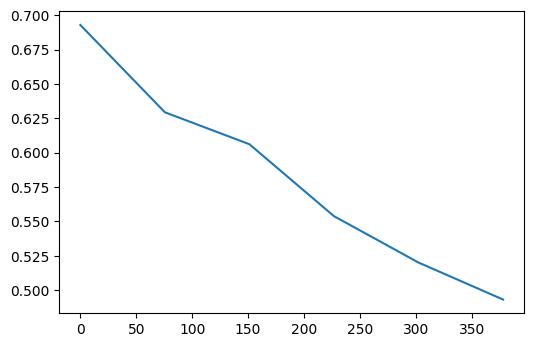

In [13]:
import numpy as np # 導人numpy數值計算函式

y = train_loss[:] # 設定Y軸為訓練損失值
x = np.linspace(0, step, len(y)) # 設定X軸為執行步階

plt.figure(dpi=100) # 設定繪圖解析度
plt.plot(x, y) # 繪圖
plt.show() # 顯示